In [126]:
import folium
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import squarify 
import pandas as pd
from matplotlib.sankey import Sankey
import seaborn as sns
import time

In [439]:
def load_census_data(directory):
    # Load census data from given directory
    df = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.csv'):
            df_temp = pd.read_csv(os.path.join(directory,filename),skiprows=1)
            df_temp["Year_ID"] = filename[:4] + df_temp['Id2'].map(str)
            df_temp = df_temp.set_index("Year_ID")
            df.append(df_temp)


    census_data = pd.concat(df)
    return census_data
def load_drug_data():
    
    census_data = load_census_data("data/census_data_2013/")
    
    drug_data = pd.read_excel('data/drug_data.xlsx', sheet_name = "Data")
    drug_data = drug_data[drug_data["YYYY"] >= 2013]
    drug_data["Year_ID"] = drug_data["YYYY"].map(str) + drug_data["FIPS_Combined"].map(str)
    drug_data = drug_data.set_index("Year_ID")
    fips = drug_data["FIPS_Combined"].map(str).apply(lambda x: x[2:])[~drug_data.index.duplicated()]
    state = drug_data[["State","YYYY"]][~drug_data.index.duplicated()]
    drug_piv = drug_data.pivot(columns="SubstanceName", values=["DrugReports"])

    drug_piv[["TotalDrugReportsCounty","TotalDrugReportsState"]] = drug_data.drop_duplicates(subset=["TotalDrugReportsCounty","TotalDrugReportsState"])[["TotalDrugReportsCounty","TotalDrugReportsState"]]
    
    drug_piv["Total"] = drug_piv["DrugReports"].sum(axis=1).fillna(0)
    drug_piv["FIPS"] = fips
    drug_piv[["State","Year"]] = state
    drug_piv["DrugReportsPerCapita"] = drug_piv["Total"]/census_data["Estimate; RELATIONSHIP - Population in households"]
    return drug_piv

drug_data = load_drug_data()



/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [447]:
drug_data.groupby(["State","FIPS"])["DrugReportsPerCapita"].mean().groupby("State").nlargest(3)

State  State  FIPS
KY     KY     013     0.010720
              095     0.007585
              193     0.007581
OH     OH     079     0.008425
              061     0.007150
              053     0.007014
PA     PA     101     0.003950
              003     0.003848
              021     0.003334
VA     VA     185     0.010230
              169     0.008037
              187     0.007773
WV     WV     067     0.007350
              041     0.005444
              055     0.004347
Name: DrugReportsPerCapita, dtype: float64

In [534]:
street_drugs = ['Opium', 'Opiates', 'Acetylcodeine']

fentanyl = ['Fentanyl', 'Acetyl fentanyl', 'Butyryl fentanyl',
       'Furanyl fentanyl', 'p-Fluorobutyryl fentanyl', 'cis-3-methylfentanyl',
       'Valeryl fentanyl', 'Carfentanil', 'Acryl fentanyl', 'U-47700',
       '3-Methylfentanyl', '4-Fluoroisobutyryl fentanyl',
       'trans-3-Methylfentanyl', 'p-methoxybutyryl fentanyl',
       'Tetrahydrofuran fentanyl', 'p-Fluorofentanyl', 'o-Fluorofentanyl',
       '3-Fluorofentanyl', 'Fluorofentanyl', 'Fluoroisobutyryl fentanyl',
       'Fluorobutyryl fentanyl ', 'Furanyl/3-Furanyl fentanyl',
       'Cyclopropyl fentanyl', 'Methoxyacetyl fentanyl', 'Phenyl fentanyl',
       'Benzylfentanyl', 'U-48800', 'U-49900', 'Crotonyl fentanyl',
       '3,4-Methylenedioxy U-47700', 'U-51754',
       'Cyclopropyl/Crotonyl Fentanyl', 'Isobutyryl fentanyl',
       'Cyclopentyl fentanyl', '4-Methylfentanyl'] 

prescription = ['Propoxyphene', 'Morphine', 'Methadone', 'Hydromorphone', 'Oxycodone',
 'Oxymorphone', 'Dextropropoxyphene', 'Buprenorphine', 'Hydrocodone', 'Meperidine',
 'Methorphan', 'Codeine', 'Tramadol', 'Pethidine', 'Dihydrocodeine',
 'Pentazocine','Thebaine', 'Butorphanol', 'ANPP',
 'Desmethylprodine ', 'Mitragynine', 'Acetyldihydrocodeine', 'Hydrocodeinone',
 'MT-45', 'Levorphanol', 'Metazocine']
HeroinData = drug_data.groupby(["State","Year"]).sum()["DrugReports"]['Heroin']
StreetDrugData = drug_data.groupby(["State","Year"]).sum()["DrugReports"][street_drugs].sum(axis=1)
FentanylData = drug_data.groupby(["State","Year"]).sum()["DrugReports"][fentanyl].sum(axis=1)
PrescriptionData = drug_data.groupby(["State","Year"]).sum()["DrugReports"][prescription].sum(axis=1)
frames = [HeroinData, StreetDrugData, FentanylData, PrescriptionData]
result = pd.concat(frames,axis=1)
result.rename(columns={0:'Other',1:'Fentanyls',2:'Prescription'},inplace=True)
result

Heroin  Other  Fentanyls  Prescription
State Year                                         
KY    2013   4175.0    0.0       25.0        6948.0
      2014   4362.0    0.0      233.0        6486.0
      2015   4045.0    0.0      536.0        5284.0
      2016   3716.0    0.0     1210.0        4167.0
      2017   3231.0    1.0     2825.0        3337.0
OH    2013  18340.0    9.0      111.0        8386.0
      2014  20590.0    0.0     1375.0        8895.0
      2015  23347.0    0.0     4344.0        9436.0
      2016  20877.0    9.0    11829.0        9755.0
      2017  15045.0    0.0    22137.0        8922.0
PA    2013  14745.0    1.0       86.0        5577.0
      2014  18454.0    2.0      439.0        6009.0
      2015  18964.0    1.0     1304.0        5382.0
      2016  17559.0    5.0     3980.0        4620.0
      2017  13256.0    0.0    10117.0        4521.0
VA    2013   4396.0   15.0      133.0        7131.0
      2014   3132.0    3.0      174.0        5728.0
      2015   3583.0    1.0      292.0        4934.0
      2016   4261.0    2.0     1038.0        4894.0
      2017   3869.0    4.0     2141.0        4434.0
WV    2013   1857.0    0.0        3.0        2186.0
      2014   1516.0    0.0       50.0        1714.0
      2015   1135.0    0.0      155.0        1281.0
      2016   1168.0    0.0      230.0        1150.0
      2017    751.0    0.0      314.0         549.0

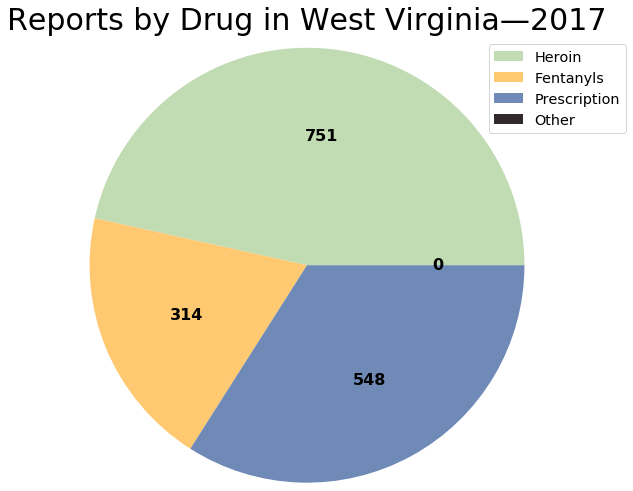

In [809]:
%matplotlib inline
#inputs:
#state="OH",ect.
#year=2013-2017
def CreatePieChart(state,year,filename=None):
    if (state == 'KY'):
        STATE = 'Kentucky'
    elif (state == 'OH'):
        STATE = "Ohio"
    elif (state == 'PA'):
        STATE = "Pennsylvania"
    elif (state == 'VA'):
        STATE = "Virginia"
    else:
        STATE = "West Virginia"
    data = [int(result.Heroin[state,year,]),int(result.Fentanyls[state,year,]),int(result.Prescription[state,year]),int(result.Other[state,year])]
    wedges, texts, autotexts = plt.pie(data,
                 colors=["#c1dbb3","#ffc971","#6F8AB7","#32292F"],
                 radius=2.5,
                 autopct = lambda pct: "{0}".format(int(pct/100*np.sum(data))),
                 )

    plt.legend(['Heroin','Fentanyls','Prescription','Other'],loc='upper right', bbox_to_anchor=(2.0, 1.55,0,0), fontsize='x-large'
    )
    plt.title('Reports by Drug in '+STATE+'\u2014'+str(year), fontdict = {'fontsize': 30, 'verticalalignment':'top'}, pad=150)
    plt.setp(autotexts, size=16, weight='bold')
    
    
    if (filename):
        plt.savefig(filename,bbox_inches='tight')
        
    plt.show()
    
CreatePieChart(state='WV',year=2017,filename='WV_DrugPieChart_2017.png')

In [451]:
#Inputs:
#state='KY','WV','OH','VA', or 'PA'
#year=2013,2014,2015, or 2016
#Type='Total','DrugReportsPerCapita'
#filename=''
def CreateStateMap(state,year,Type,filename=None):
    #Sets Topojson and coordinates for inputted state
    if (state == "KY"):
        STATE = os.path.join('data', 'KY-21-kentucky-counties.json')
        TOPOS = 'objects.cb_2015_kentucky_county_20m'
        Cords = [37.494283, -85.445286]
    elif (state == "WV"):
        STATE = os.path.join('data', 'WV-54-west-virginia-counties.json')
        TOPOS = 'objects.cb_2015_west_virginia_county_20m'
        Cords = [38.90, -80.95]
    elif (state == "OH"):
        STATE = os.path.join('data', 'OH-39-ohio-counties.json')
        TOPOS = 'objects.cb_2015_ohio_county_20m'
        Cords = [40.25, -82.50]
    elif (state == "VA"):
        STATE = os.path.join('data', 'VA-51-virginia-counties.json')
        TOPOS = 'objects.cb_2015_virginia_county_20m'
        Cords = [37.728, -79.40]
    else:
        STATE = os.path.join('data', 'PA-42-pennsylvania-counties.json')
        TOPOS = 'objects.cb_2015_pennsylvania_county_20m'
        Cords = [40.81, -77.827679]

    #Create Map 
    M = folium.Map(
    location = Cords,
    zoom_start=8,
    tiles='cartodbpositron'
    )
    
    #Pull correct data
    DATA = drug_data[(drug_data["State"]==state) & (drug_data["Year"]==year)]
    
    #Create layer
    folium.Choropleth(
        open(STATE),
        topojson = TOPOS,
        data=DATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 319, 638, 957, 1276, 1595, 1914],
        highlight = True
        ).add_to(M)
    
    #save file if wanted
    if (filename):
        M.save(outfile=filename)
        
    #Output map
    return M
        
#CreateStateMap(state,year,Type,filename=None)       

In [438]:
#Inputs:
#year=2013,2014,2015, or 2016
#Type='Total','DrugReportsPerCapita'
#filename=''
def CreateAllStatesMap(year,Type,filename=None):
    #Sets Topojson and coordinates for states
    KENT = os.path.join('data', 'KY-21-kentucky-counties.json')
    WESTV = os.path.join('data', 'WV-54-west-virginia-counties.json')
    OHIO = os.path.join('data', 'OH-39-ohio-counties.json')
    VIRG = os.path.join('data', 'VA-51-virginia-counties.json')
    PENN = os.path.join('data', 'PA-42-pennsylvania-counties.json')

    #Create Map 
    M = folium.Map(
    location = [39.25,-80.82],
    zoom_start=7,
    tiles='cartodbpositron'
    )
    
    #Pull all state data
    KENTDATA = drug_data[(drug_data["State"]=='KY') & (drug_data["Year"]==year)]
    WESTVDATA = drug_data[(drug_data["State"]=='WV') & (drug_data["Year"]==year)]
    OHIODATA = drug_data[(drug_data["State"]=='OH') & (drug_data["Year"]==year)]
    VIRGDATA = drug_data[(drug_data["State"]=='VA') & (drug_data["Year"]==year)]
    PENNDATA = drug_data[(drug_data["State"]=='PA') & (drug_data["Year"]==year)]
    
    #Create layers
    folium.Choropleth(
        open(KENT),
        topojson = 'objects.cb_2015_kentucky_county_20m',
        data=KENTDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(WESTV),
        topojson = 'objects.cb_2015_west_virginia_county_20m',
        data=WESTVDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(OHIO),
        topojson = 'objects.cb_2015_ohio_county_20m',
        data=OHIODATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(VIRG),
        topojson = 'objects.cb_2015_virginia_county_20m',
        data=VIRGDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    folium.Choropleth(
        open(PENN),
        topojson = 'objects.cb_2015_pennsylvania_county_20m',
        data=PENNDATA,
        columns=['FIPS', Type],
        key_on='feature.properties.COUNTYFP',
        fill_color = 'OrRd',
        nan_fill_color = 'Black',
        line_weight = 2,
        line_opacity = 0.5,
        legend_name = 'Total opioid drug reports',
        threshold_scale= [0, 1333, 2666, 3999, 5332, 6665, 7998],
        highlight = True
        ).add_to(M)
    
    #save file if wanted
    if (filename):
        M.save(outfile=filename)
        
    #Output map
    return M


#CreateAllStatesMap(2016,'Total',filename='AllStates_TotalOpioidReports_2016.html')

In [111]:
Penn = os.path.join('data', 'PA-42-pennsylvania-counties.json')


P = folium.Map(
    location=[40.885405, -77.827679],
    zoom_start=7,
    tiles='cartodbpositron'
)

#folium.TopoJson(
#    open(Penn),
#    'objects.cb_2015_pennsylvania_county_20m',
#    name='Penntopojson'
#)

folium.Choropleth(
    open(Penn),
    topojson='objects.cb_2015_pennsylvania_county_20m',
    #name='Pennchoropleth'
    #data=state_data,
    #columns=['State', 'Unemployment'],
    #key_on='feature.id',
    fill_color='BuGn',
    fill_opacity=0.4
    #line_opacity=0.2
    #legend_name='Unemployment Rate (%)'
).add_to(P)
P

In [86]:
WestV = os.path.join('data', 'WV-54-west-virginia-counties.json')


WV = folium.Map(
    location=[38.678190, -80.716949],
    zoom_start=7,
    tiles='cartodbdark_matter'
)

#folium.TopoJson(
#    open(WestV),
#    'objects.cb_2015_west_virginia_county_20m',
#    name='WVjson'
#).add_to(WV)
#folium.LayerControl().add_to(P)

folium.Choropleth(
    open(WestV),
    topojson='objects.cb_2015_west_virginia_county_20m',
    #name='Pennchoropleth'
    #data=state_data,
    #columns=['State', 'Unemployment'],
    #key_on='feature.id',
    fill_color='#f29d9d',
    line_color='#f0dede',
    line_weight=2,
    fill_opacity=0.3,
    highlight=True
    #line_opacity=0.2
    #legend_name='Unemployment Rate (%)'
).add_to(WV)

WV

In [142]:
Ohio = os.path.join('data', 'OH-39-ohio-counties.json')


O = folium.Map(
    location=[40.218927, -82.762618],
    zoom_start=7,
    tiles='OpenStreetMap'
)

folium.TopoJson(
    open(Ohio),
    'objects.cb_2015_ohio_county_20m',
    name='Ojson'
).add_to(O)
#folium.LayerControl().add_to(P)
O

In [440]:
drug_data["DrugReports"].columns

Index(['3,4-Methylenedioxy U-47700', '3-Fluorofentanyl', '3-Methylfentanyl',
       '4-Fluoroisobutyryl fentanyl', '4-Methylfentanyl', 'ANPP',
       'Acetyl fentanyl', 'Acetylcodeine', 'Acetyldihydrocodeine',
       'Acryl fentanyl', 'Benzylfentanyl', 'Buprenorphine', 'Butorphanol',
       'Butyryl fentanyl', 'Carfentanil', 'Codeine', 'Crotonyl fentanyl',
       'Cyclopentyl fentanyl', 'Cyclopropyl fentanyl',
       'Cyclopropyl/Crotonyl Fentanyl', 'Desmethylprodine ',
       'Dextropropoxyphene', 'Dihydrocodeine', 'Fentanyl',
       'Fluorobutyryl fentanyl ', 'Fluorofentanyl',
       'Fluoroisobutyryl fentanyl', 'Furanyl fentanyl',
       'Furanyl/3-Furanyl fentanyl', 'Heroin', 'Hydrocodeinone', 'Hydrocodone',
       'Hydromorphone', 'Isobutyryl fentanyl', 'Levorphanol', 'MT-45',
       'Meperidine', 'Metazocine', 'Methadone', 'Methorphan',
       'Methoxyacetyl fentanyl', 'Mitragynine', 'Morphine', 'Opiates', 'Opium',
       'Oxycodone', 'Oxymorphone', 'Pentazocine', 'Pethidine',
  

Text(0.5, 1.0, 'Sankey diagram with default settings')

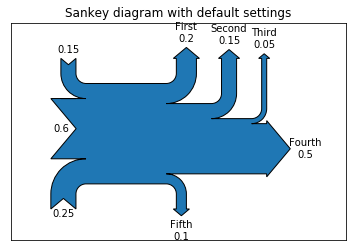

In [25]:
 # basic sankey chart
Sankey(flows=[0.25, 0.15, 0.60, -0.20, -0.15, -0.05, -0.50, -0.10], labels=['', '', '', 'First', 'Second', 'Third', 'Fourth', 'Fifth'], orientations=[-1, 1, 0, 1, 1, 1, 0,-1]).finish()
plt.title("Sankey diagram with default settings")

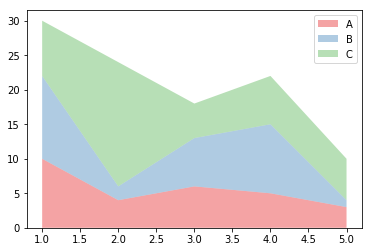

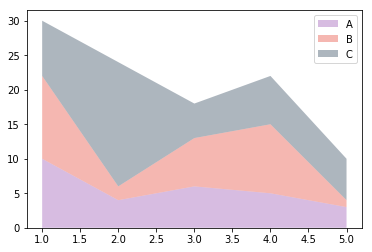

In [26]:
# Your x and y axis
x=range(1,6)
y=[ [10,4,6,5,3], [12,2,7,10,1], [8,18,5,7,6] ]
 
# use a known color palette (see..)
pal = sns.color_palette("Set1")
plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
plt.show()
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')

/home/ryanibarra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  This is separate from the ipykernel package so we can avoid doing imports until


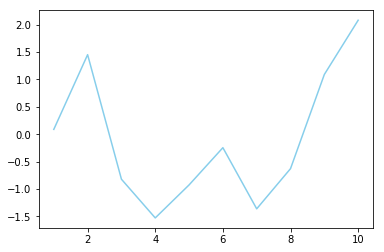

In [27]:
%matplotlib inline
df=pd.DataFrame({'x': range(1,11), 'y': np.random.randn(10) })
plt.plot( 'x', 'y', data=df, color='skyblue')
plt.show()